In [1]:
import sqlite3
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
#!pip install psycopg2-binary

In [3]:
import psycopg2 as pg

# Call DB

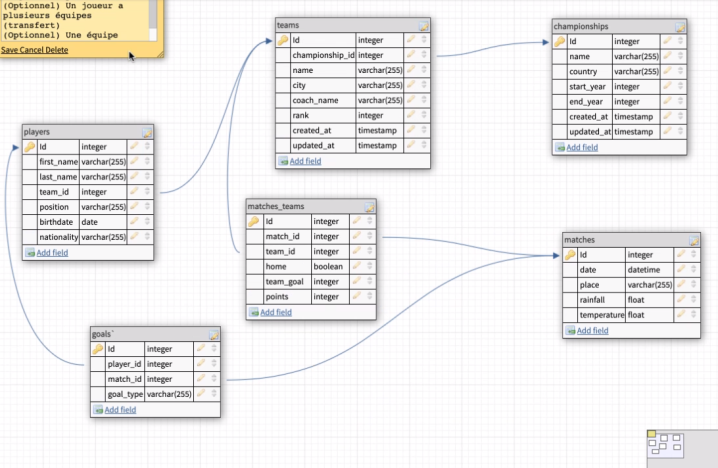

In [4]:
#Connexion
#conn = sqlite3.connect('data.sqlite')
conn = pg.connect(dbname='d18d5k6eqpagnc',
                  user='qshqwgcxyldiib',
                  host='ec2-54-74-14-109.eu-west-1.compute.amazonaws.com',
                  password = '726d500b6531d0c8fb04410eb021d11ccccb5f369efa9cb7045538a1f56a8faa')
cursor = conn.cursor()

In [5]:
def view_table(table):
    df_db = pd.read_sql_query(f"""
    SELECT *
    FROM {table}
    ;""", conn)
    display(df_db.head(3))
    display(df_db.shape)

In [6]:
view_table('matches')

,id,date,place,rainfall,temperature
0,1,,Bordeaux,5.0,22.5
1,2,,Dijon,19.0,22.0
2,3,,Lille,1.0,19.0


(380, 5)

In [7]:
view_table('matches_teams')

,id,match_id,team_id,home,team_goal,points
0,1,1,2,1,0,1
1,2,1,13,0,0,1
2,3,2,4,1,0,0


(760, 6)

# Evolution du nombre de buts d’une équipe en fonction de la météo (pluviométrie, température)

In [8]:
#create DF
data = pd.read_sql(f"""
SELECT t.city, mt.team_goal, m.temperature, m.rainfall
FROM matches_teams AS mt
JOIN matches as m
ON m.id = mt.match_id
JOIN teams as t
ON mt.team_id = t.id
;""", conn)

# Evolution du nombre de buts d’un joueur en fonction de la météo (pluviométrie, température)

In [9]:
#create DF
data2 = pd.read_sql(f"""
SELECT g.match_id, p.last_name, t.city, m.temperature, m.rainfall
FROM goals AS g
JOIN players as p
ON p.id = g.player_id
JOIN matches as m
ON g.match_id = m.id
join teams as t
ON p.team_id = t.id
;""", conn)
data2

,match_id,last_name,city,temperature,rainfall
0,2,I. Traoré,Angers,22.0,19.0
1,3,J. Bamba,Lille,19.0,1.0
2,3,D. Da Silva,Rennes,19.0,1.0
3,4,A. Disasi,Monaco,25.5,1.0
4,4,B. Badiashile,Monaco,25.5,1.0
...,...,...,...,...,...
1044,379,E. Touré,Reims,10.5,1.0
1045,379,Y. Adli,Bordeaux,10.5,1.0
1046,379,E. Kwateng,Bordeaux,10.5,1.0
1047,380,H. Diallo,Strasbourg,12.0,2.0


In [10]:
data2['buts'] = 1

In [43]:
df = data2.sort_values(['match_id','last_name'], ascending=True).assign(delete=np.nan)

for i in range(len(df)):
    if i < len(df)-1:   
        if df.iloc[i]['last_name'] == df.iloc[i+1]['last_name']:  
            buts = df.iloc[i]['buts'] + df.iloc[i+1]['buts']
            df.at[i+1, 'buts'] = buts
            df.at[i, 'delete'] = 1
            
df3 = df[df['delete'] != 1].drop('delete', axis = 1)

In [20]:
df3[df3['buts'] == 3]

,match_id,last_name,city,temperature,rainfall,buts
27,11,M. Depay,Lyon,21.5,20.0,3
152,58,I. Niane,Metz,11.0,18.0,3
202,73,K. Mbappé,Paris-SG,14.5,1.0,3
205,74,N. Mbuku,Reims,15.5,0.0,3
668,244,T. Moffi,Lorient,6.5,1.0,3
856,317,Z. Youssouf,Saint-Étienne,11.5,14.0,3
923,338,T. Moffi,Lorient,13.5,0.0,3
1011,365,A. Milik,Marseille,15.5,1.0,3


In [21]:
def team_bar_meteo(team):

    #-------------------------------------------------------------------------------
    #plot nb of goals by temperature and rainfall for a team
    #return none

    print("")
    fig, ax = plt.subplots(1, 2, figsize=(20,8))
    sns.barplot(data=data[data['city'] == team], x='temperature', y='team_goal', ax=ax[0])
    sns.barplot(data=data[data['city'] == team], x='rainfall', y='team_goal', ax=ax[1])
    plt.suptitle(f'Distributions des buts de {team}', fontsize = 30, fontweight = 'bold')
    ax[0].set_title(f"Nb de buts en fonction de la temperature", fontsize = 14, fontweight = 'bold')
    ax[1].set_title(f"Nb de buts en fonction de la pluviométrie", fontsize = 14, fontweight = 'bold')
    plt.show()
    return None
    
def player_bar_meteo(player):

    #-------------------------------------------------------------------------------
    #plot nb of goals by temperature and rainfall for a team
    #return none

    print("")
    fig, ax = plt.subplots(1, 2, figsize=(20,8))
    sns.barplot(data=df3[df3['last_name'] == player], x='temperature', y='buts', ax=ax[0])
    sns.barplot(data=df3[df3['last_name'] == player], x='rainfall', y='buts', ax=ax[1])
    plt.suptitle(f'Distributions des buts de {player}', fontsize = 30, fontweight = 'bold')
    ax[0].set_title(f"Nb de buts en fonction de la temperature", fontsize = 14, fontweight = 'bold')
    ax[1].set_title(f"Nb de buts en fonction de la pluviométrie", fontsize = 14, fontweight = 'bold')
    plt.show()
    return None

In [14]:
interact(team_bar_meteo, team=data['city'].unique())

interactive(children=(Dropdown(description='team', options=('Bordeaux', 'Nantes', 'Dijon', 'Angers', 'Lille', …

<function __main__.team_bar_meteo(team)>

In [22]:
interact(player_bar_meteo, player=data2['last_name'].unique())

interactive(children=(Dropdown(description='player', options=('I. Traoré', 'J. Bamba', 'D. Da Silva', 'A. Disa…

<function __main__.player_bar_meteo(player)>

In [44]:
df3['last_name'][df3['buts'] == 0].value_counts()

Series([], Name: last_name, dtype: int64)

In [50]:
data2['buts'][data2['last_name'] == 'K. Mbappé'].sum()

27